### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)

In [9]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from os import walk

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from scipy import stats

#### Load all sheets in the underlying file

In [10]:
file_path = '../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

file_list = []
for (dirpath, dirnames, filenames) in walk(file_path):
    file_list.extend(filenames)
    break

file_list = [x for x in file_list if x[-3:] == 'csv']

In [11]:
##sheet = client.open('Learning Log').sheet1

raw_df = pd.DataFrame()
for file_name in file_list:
    sub_table = pd.read_csv(file_path + file_name)
    sub_table['sheet_name'] = file_name.split('.')[0]
    raw_df = pd.concat([raw_df, sub_table])

raw_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name
0,Hubei,Mainland China,2020-02-18T23:13:11,61682.0,1921.0,9128.0,02-18-2020
1,Guangdong,Mainland China,2020-02-18T13:43:02,1328.0,4.0,565.0,02-18-2020
2,Henan,Mainland China,2020-02-18T14:23:02,1257.0,19.0,522.0,02-18-2020
3,Zhejiang,Mainland China,2020-02-18T12:23:02,1172.0,0.0,535.0,02-18-2020
4,Hunan,Mainland China,2020-02-18T13:43:02,1007.0,4.0,527.0,02-18-2020


In [12]:
raw_df.describe(include=[np.object])

,Province/State,Country/Region,Last Update,sheet_name
count,1718,2379,2379,2379
unique,72,46,686,35
top,Anhui,Mainland China,1/31/2020 23:59,02-25-2020
freq,35,1079,62,94


In [13]:
# Merge duplicate columns with different names

main_df = raw_df

# main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
# main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

# main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

# main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update', '',
                                                'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'
                                                'Announcement'])]

## main_df = main_df.drop(columns=['Announcement',
                      ## 'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])

main_df.sample(5)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name
15,Shaanxi,Mainland China,2020-02-07T08:23:09,184.0,0.0,17.0,02-07-2020
9,Shandong,Mainland China,2020-02-08T11:33:02,416.0,0.0,44.0,02-08-2020
50,From Diamond Princess,Australia,2020-02-21T23:03:13,4.0,0.0,0.0,02-21-2020
7,Chongqing,Mainland China,2020-02-02T23:33:02,300.0,2.0,7.0,02-02-2020
81,Switzerland,Switzerland,2020-02-25T19:13:21,1.0,0.0,0.0,02-25-2020


In [14]:
main_df.sheet_name.str.split('-')

0     [02, 18, 2020]
1     [02, 18, 2020]
2     [02, 18, 2020]
3     [02, 18, 2020]
4     [02, 18, 2020]
           ...      
62    [02, 01, 2020]
63    [02, 01, 2020]
64    [02, 01, 2020]
65    [02, 01, 2020]
66    [02, 01, 2020]
Name: sheet_name, Length: 2379, dtype: object

In [15]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('-').apply(lambda x: x[0])
main_df['day'] = main_df.sheet_name.str.split('-').apply(lambda x: x[1])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
# main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

main_df.loc[main_df['Province/State'] == 'Macau','Country/Region'] = 'Macau'
main_df.loc[main_df['Province/State'] == 'Hong Kong','Country/Region'] = 'Hong Kong'

In [16]:
main_df

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,sheet_name,month,day
0,Hubei,Mainland China,2020-02-18 21:13:11,61682.0,1921.0,9128.0,02-18-2020,02,18
1,Guangdong,Mainland China,2020-02-18 11:43:02,1328.0,4.0,565.0,02-18-2020,02,18
2,Henan,Mainland China,2020-02-18 12:23:02,1257.0,19.0,522.0,02-18-2020,02,18
3,Zhejiang,Mainland China,2020-02-18 10:23:02,1172.0,0.0,535.0,02-18-2020,02,18
4,Hunan,Mainland China,2020-02-18 11:43:02,1007.0,4.0,527.0,02-18-2020,02,18
...,...,...,...,...,...,...,...,...,...
62,"Los Angeles, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
63,"Orange, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
64,"Santa Clara, CA",US,2020-02-01 17:53:00,1.0,0.0,0.0,02-01-2020,02,01
65,"Seattle, WA",US,2020-02-01 17:43:00,1.0,0.0,0.0,02-01-2020,02,01


In [17]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  ## 'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period
0,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24
1,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25
2,Algeria,Algeria,02,25,2020-02-25 21:43:03,1.0,0.0,0.0,2020-02-25
3,Australia,Australia,01,23,2020-01-23 15:00:00,0.0,0.0,0.0,2020-01-23
4,Australia,Australia,01,25,2020-01-25 15:00:00,4.0,0.0,0.0,2020-01-25
...,...,...,...,...,...,...,...,...,...
2374,Vietnam,Vietnam,02,21,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-21
2375,Vietnam,Vietnam,02,22,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-22
2376,Vietnam,Vietnam,02,23,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-23
2377,Vietnam,Vietnam,02,24,2020-02-21 04:03:04,16.0,14.0,0.0,2020-02-24


#### Some baisc checks

2020-01-22 15:00:00    38
2020-01-23 15:00:00    46
2020-01-24 15:00:00    41
2020-01-25 15:00:00    44
2020-01-26 14:00:00    47
                       ..
2020-02-25 19:33:02     2
2020-02-25 21:13:03     1
2020-02-25 21:23:03     1
2020-02-25 21:43:03     2
2020-02-25 21:53:02     1
Name: Last Update, Length: 685, dtype: int64

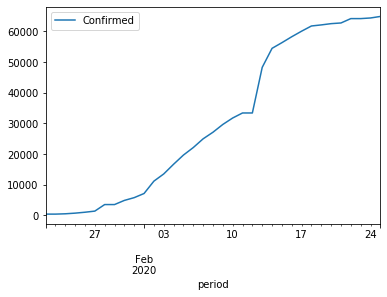

In [18]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

In [19]:
clean_df['Province/State'].value_counts().sort_values().head(20)

Ivory Coast                                    1
Lackland, TX                                   1
Algeria                                        1
Travis, CA                                     1
Ashland, NE                                    1
Switzerland                                    1
Chicago                                        1
Mexico                                         1
Colombia                                       1
Brazil                                         1
Croatia                                        1
Cruise Ship                                    2
Unassigned Location (From Diamond Princess)    2
Bahrain                                        2
Oman                                           2
Afghanistan                                    2
Iraq                                           2
Kuwait                                         2
None                                           3
Australia                                      3
Name: Province/State

In [20]:
clean_df['Province/State'].value_counts().sort_values().head(10).index

Index(['Ivory Coast', 'Lackland, TX', 'Algeria', 'Travis, CA', 'Ashland, NE',
       'Switzerland', 'Chicago', 'Mexico', 'Colombia', 'Brazil'],
      dtype='object')

### Some Analysis on virus spread

##### Growth rate of confirmed cases

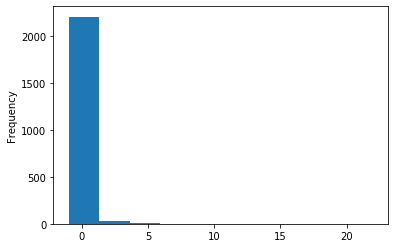

In [21]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [22]:
clean_df[clean_df['growth rate daily']<0]

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
42,Australia,Queensland,01,31,2020-01-31 21:59:00,2.0,0.0,0.0,2020-01-31,3.0,-1.0,-0.333333
44,Australia,Queensland,02,02,2020-02-02 20:33:07,2.0,0.0,0.0,2020-02-02,3.0,-1.0,-0.333333
436,Iraq,None,02,23,2020-02-23 16:23:06,0.0,0.0,0.0,2020-02-23,2.0,-2.0,-1.000000
437,Israel,From Diamond Princess,02,21,2020-02-21 13:33:03,1.0,0.0,0.0,2020-02-21,7.0,-6.0,-0.857143
470,Japan,Japan,01,23,2020-01-23 15:00:00,1.0,0.0,0.0,2020-01-23,2.0,-1.0,-0.500000
485,Japan,Japan,02,07,2020-02-07 02:13:20,25.0,1.0,0.0,2020-02-07,45.0,-20.0,-0.444444
2092,US,"Lackland, TX (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,2.0,-2.0,-1.000000
2142,US,"Omaha, NE (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,11.0,-11.0,-1.000000
2303,US,"Travis, CA (From Diamond Princess)",02,24,2020-02-24 21:33:02,0.0,0.0,0.0,2020-02-24,5.0,-5.0,-1.000000


In [23]:
# focus on cases where base is above 20
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 20]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,1360.687873,238.753479,36.094433,1282.439364,78.248509,0.105902,14.548708
std,7251.982245,1321.427938,241.118014,6972.108824,591.153144,0.197040,8.694203
min,20.000000,0.000000,0.000000,20.000000,-20.000000,-0.444444,1.000000
25%,74.000000,4.000000,0.000000,67.250000,1.000000,0.003353,7.000000
50%,162.500000,24.000000,1.000000,146.000000,6.000000,0.037568,14.000000
75%,468.000000,102.000000,2.000000,436.000000,20.750000,0.121338,21.000000
max,64786.000000,18971.000000,2563.000000,64287.000000,14840.000000,2.354839,34.000000


In [24]:
growth_df = heavy_affect_df.\
    pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').\
    reset_index()
growth_df

Province/State,day count,Anhui,Beijing,Chongqing,Cruise Ship,Diamond Princess cruise ship,Fujian,Gansu,Guangdong,Guangxi,...,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Unassigned Location (From Diamond Princess),Xinjiang,Yunnan,Zhejiang
0,1.0,0.538462,0.636364,1.111111,0.0,1.109375,0.685714,0.083333,0.230769,0.000000,...,0.571429,0.166667,0.043478,0.100000,0.000000,0.043478,0.0,0.142857,0.692308,0.592593
1,2.0,0.166667,0.138889,0.315789,NaN,0.000000,0.355932,0.115385,0.656250,0.565217,...,0.568182,0.000000,0.000000,0.000000,0.000000,0.125000,NaN,0.208333,0.250000,0.441860
2,3.0,0.514286,0.658537,0.466667,NaN,0.296296,0.050000,0.379310,0.471698,0.277778,...,0.304348,0.071429,0.041667,0.045455,0.000000,0.148148,NaN,0.103448,0.272727,0.677419
3,4.0,0.433962,0.176471,0.200000,NaN,0.000000,0.202381,0.275000,0.423077,0.108696,...,0.200000,0.100000,0.080000,0.043478,0.280000,0.032258,NaN,0.125000,0.185714,0.230769
4,5.0,0.315789,0.137500,0.113636,NaN,0.245714,0.188119,0.078431,0.360360,0.137255,...,0.314815,0.212121,0.037037,0.083333,0.000000,0.281250,NaN,0.083333,0.120482,0.351562
5,6.0,0.185000,0.219780,0.238095,NaN,0.307339,0.200000,0.036364,0.370861,0.344828,...,0.246479,0.125000,0.000000,0.000000,0.000000,0.170732,NaN,0.076923,0.129032,0.710983
6,7.0,0.253165,0.027027,0.159341,NaN,0.245614,0.104167,0.087719,0.338164,0.115385,...,0.169492,0.044444,0.000000,0.076923,0.031250,0.250000,NaN,0.071429,0.114286,0.445946
7,8.0,0.144781,0.219298,0.170616,NaN,0.278873,0.125786,0.000000,0.277978,0.149425,...,0.115942,0.063830,0.000000,0.071429,0.000000,0.116667,NaN,0.088889,0.042735,0.257009
8,9.0,0.200000,0.208633,0.214575,NaN,0.193833,0.083799,0.080645,0.231638,0.110000,...,0.099567,0.160000,0.000000,0.033333,0.000000,0.029851,NaN,0.122449,0.049180,0.113383
9,10.0,0.176471,0.136905,0.123333,NaN,0.145756,0.056701,0.179104,0.227064,0.144144,...,0.110236,0.155172,0.035714,NaN,0.000000,0.144928,NaN,0.072727,0.039062,0.103506


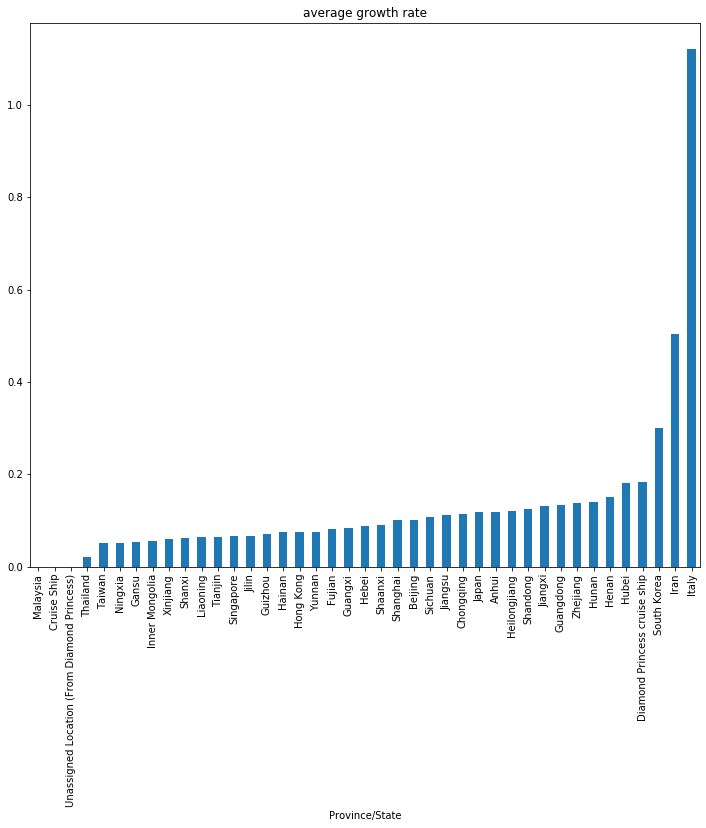

In [25]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().\
    sort_values().plot.bar(figsize=(12,10),title='average growth rate')

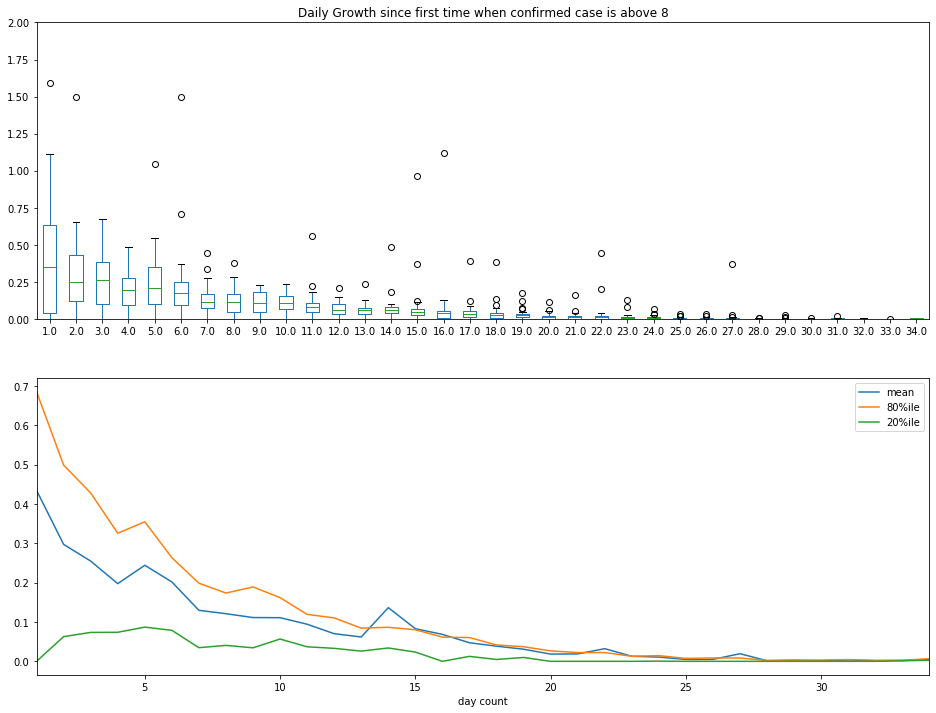

In [26]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize =(16,12))

growth_df.set_index('day count').transpose().plot.box(ax = axes[0], 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

# deceleration? caveat: ommision bias
growth_df.set_index('day count').mean(axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot(ax = axes[1])
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot(ax = axes[1])

axes[1].legend(['mean','80%ile','20%ile'])

In [27]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
15,Hubei,444.0
4,Diamond Princess cruise ship,135.0
13,Henan,83.0
22,Jiangxi,72.0
19,Italy,62.0


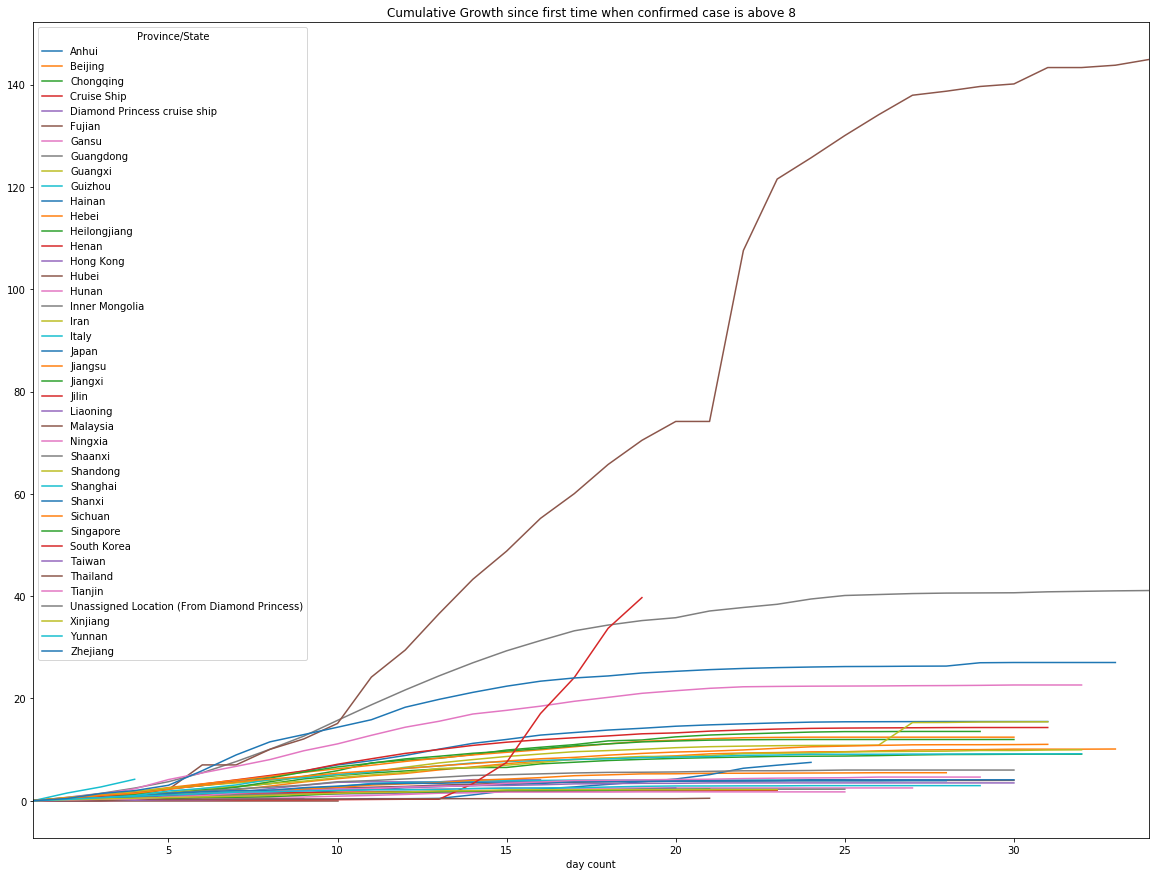

In [28]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')

heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')

cmlt_growth_df.plot.line(figsize =(20, 15), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

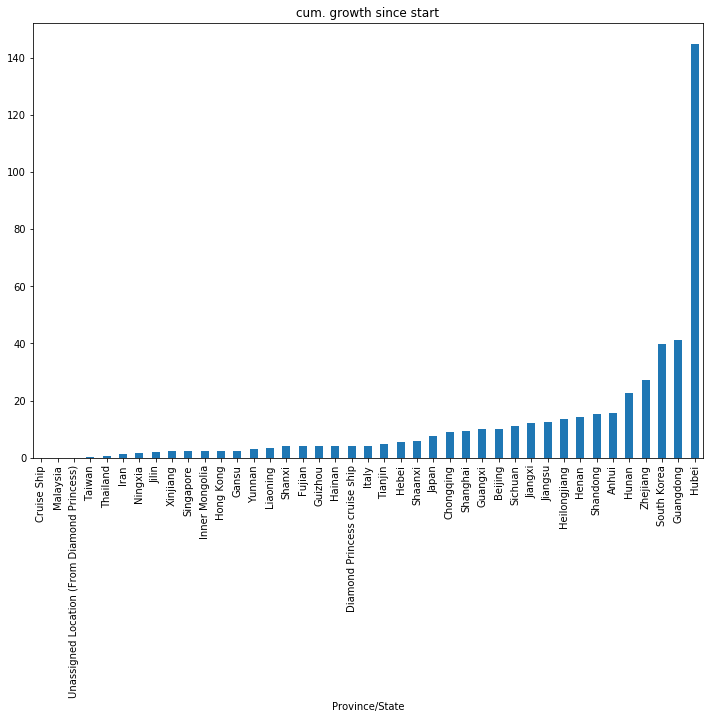

In [29]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8), title='cum. growth since start')

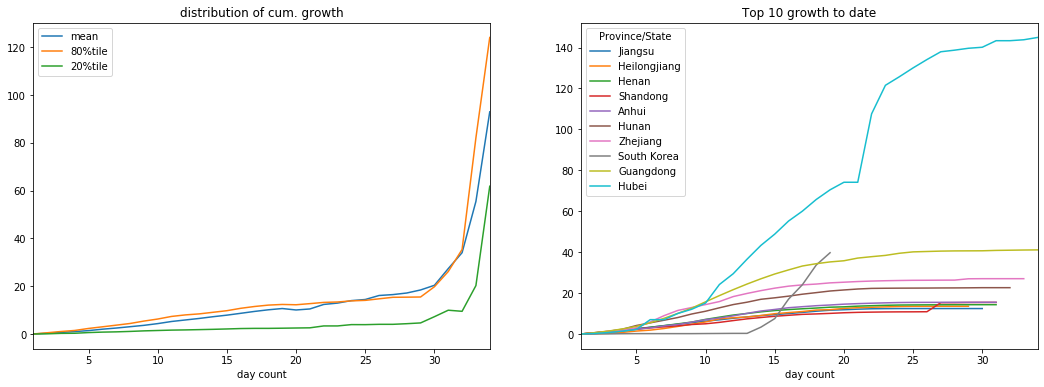

In [30]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.8,axis=1).plot(ax = axes[0])
cmlt_growth_df.quantile(q=0.2,axis=1).plot(ax = axes[0], title ='distribution of cum. growth')

axes[0].legend(['mean','80%tile', '20%tile'])

# the following provinces/states have the top 10 cumulative growth
cmlt_growth_df[cmlt_growth_df.max().sort_values().index.tolist()[-10:]].plot.line(ax =axes[1],  
                                                                                  title = 'Top 10 growth to date')

#### Compare China vs. Outside

In [31]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [32]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

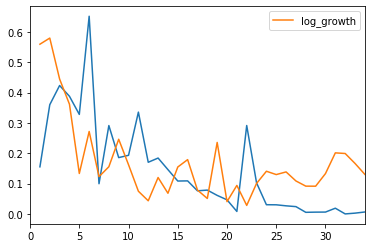

In [33]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

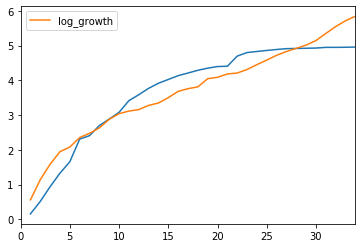

In [34]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

In [35]:
# The null hypothesis that the two distribution the same can't be reject by a simple T-test
stats.ttest_ind(china_agg_df.log_growth.dropna(), outside_agg_df.log_growth.dropna())

Ttest_indResult(statistic=-0.7411677157861112, pvalue=0.46122079639761204)

#### Time-series Analysis on Growth Rate

In [36]:
# auto-correlation is high in China 🇨🇳  on aggregate
print(acf(china_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is not significant
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.55969826  0.59974487  0.5019512   0.37478833  0.34210045
  0.24627381  0.21107442  0.17958879  0.12149827  0.0303589   0.0221589
 -0.04607583 -0.07121157 -0.07992442 -0.19384688 -0.05203801 -0.14036673
 -0.17424652 -0.16837559 -0.18973513 -0.26675431 -0.2949983  -0.2951147
 -0.27306101 -0.26197337 -0.26825539 -0.24188401 -0.24813056 -0.16143574
 -0.13250178 -0.08852897 -0.03908699 -0.0016904 ]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   34
Model:                     AutoReg(1)   Log Likelihood                  20.973
Method:               Conditional MLE   S.D. of innovations              0.128
Date:                Wed, 26 Feb 2020   AIC                             -3.927
Time:                        10:57:33   BIC                             -3.791
Sample:                             1   HQIC                            -3.881
                                   34                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0594      0.031      1.904      0.057      -0.002       0.120
log_growth.L1     0.5741      0.145      3.953      0.000       0.289       0.859
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7419           +0.0000j            1.7419            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
# auto-correlation is quite high outside of China
print(acf(outside_agg_df['log_growth'].dropna()))

# this consistent with AR test, whose lag is significant
model = AutoReg(outside_agg_df['log_growth'].dropna(), lags=1) # unable to run VAR due to missing values (synthetic control?)
results = model.fit()
results.summary()

[ 1.          0.64325622  0.42179701  0.23521657  0.11439166  0.13472274
  0.09940891  0.11056352  0.02710134 -0.07118096 -0.11155448 -0.12691186
 -0.07771619 -0.05268667 -0.07890235 -0.05494095 -0.12453679 -0.08869886
 -0.1201733  -0.23963241 -0.20186047 -0.1766627  -0.08712472 -0.08089043
 -0.1102515  -0.12839678 -0.14238162 -0.11599547 -0.06369778  0.00889395
  0.02286537 -0.00465169 -0.03212442 -0.02724489]


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   34
Model:                     AutoReg(1)   Log Likelihood                  38.388
Method:               Conditional MLE   S.D. of innovations              0.076
Date:                Wed, 26 Feb 2020   AIC                             -4.983
Time:                        10:57:33   BIC                             -4.847
Sample:                             1   HQIC                            -4.937
                                   34                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0483      0.022      2.238      0.025       0.006       0.091
log_growth.L1     0.6460      0.099      6.545      0.000       0.453       0.839
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5480           +0.0000j            1.5480            0.0000
-----------------------------------------------------------------------------
"""

#### Predictive Models for Singapore

In [38]:
outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Deaths':'max'}).reset_index()

,Country/Region,Province/State,period,Confirmed,Recovered,Deaths
0,Afghanistan,Afghanistan,2020-02-24,1.0,0.0,0.0
1,Afghanistan,Afghanistan,2020-02-25,1.0,0.0,0.0
2,Algeria,Algeria,2020-02-25,1.0,0.0,0.0
3,Australia,Australia,2020-01-23,0.0,0.0,0.0
4,Australia,Australia,2020-01-25,4.0,0.0,0.0
...,...,...,...,...,...,...
1295,Vietnam,Vietnam,2020-02-21,16.0,14.0,0.0
1296,Vietnam,Vietnam,2020-02-22,16.0,14.0,0.0
1297,Vietnam,Vietnam,2020-02-23,16.0,14.0,0.0
1298,Vietnam,Vietnam,2020-02-24,16.0,14.0,0.0


#### Apply econometric model given 1) small dataset and 2) preference for confidence interval

In [39]:
model_df = growth_df[growth_df.index <= growth_df[growth_df['Singapore'].isna() == False].index.max()].\
    set_index('day count')
model_df = model_df.dropna(axis=1)
model_df

Province/State,Anhui,Beijing,Chongqing,Fujian,Gansu,Guangdong,Guangxi,Guizhou,Hainan,Hebei,...,Shandong,Shanghai,Shanxi,Sichuan,Singapore,Thailand,Tianjin,Xinjiang,Yunnan,Zhejiang
day count,,,,,,,,,,,,,,,,,,,,,
1.0,0.538462,0.636364,1.111111,0.685714,0.083333,0.230769,0.000000,0.000000,0.500000,0.454545,...,0.703704,0.650000,0.000000,0.571429,0.166667,0.000000,0.043478,0.142857,0.692308,0.592593
2.0,0.166667,0.138889,0.315789,0.355932,0.115385,0.656250,0.565217,0.310345,0.212121,0.354167,...,0.630435,0.212121,0.296296,0.568182,0.000000,0.000000,0.125000,0.208333,0.250000,0.441860
3.0,0.514286,0.658537,0.466667,0.050000,0.379310,0.471698,0.277778,0.210526,0.075000,0.261538,...,0.266667,0.325000,0.114286,0.304348,0.071429,0.000000,0.148148,0.103448,0.272727,0.677419
4.0,0.433962,0.176471,0.200000,0.202381,0.275000,0.423077,0.108696,0.260870,0.069767,0.170732,...,0.368421,0.245283,0.205128,0.200000,0.100000,0.280000,0.032258,0.125000,0.185714,0.230769
5.0,0.315789,0.137500,0.113636,0.188119,0.078431,0.360360,0.137255,0.103448,0.130435,0.083333,...,0.215385,0.454545,0.404255,0.314815,0.212121,0.000000,0.281250,0.083333,0.120482,0.351562
6.0,0.185000,0.219780,0.238095,0.200000,0.036364,0.370861,0.344828,0.109375,0.192308,0.086538,...,0.164557,0.166667,0.121212,0.246479,0.125000,0.000000,0.170732,0.076923,0.129032,0.710983
7.0,0.253165,0.027027,0.159341,0.104167,0.087719,0.338164,0.115385,0.140845,0.032258,0.115044,...,0.119565,0.205357,0.094595,0.169492,0.044444,0.031250,0.250000,0.071429,0.114286,0.445946
8.0,0.144781,0.219298,0.170616,0.125786,0.000000,0.277978,0.149425,0.098765,0.125000,0.071429,...,0.116505,0.251852,0.000000,0.115942,0.063830,0.000000,0.116667,0.088889,0.042735,0.257009
9.0,0.200000,0.208633,0.214575,0.083799,0.080645,0.231638,0.110000,0.112360,0.111111,0.162963,...,0.126087,0.076923,0.185185,0.099567,0.160000,0.000000,0.029851,0.122449,0.049180,0.113383


In [40]:
model_df.corr()['Singapore'].sort_values(ascending=False).head(10)

Province/State
Singapore       1.000000
Heilongjiang    0.739833
Shanghai        0.647985
Shaanxi         0.631193
Anhui           0.610538
Hainan          0.578191
Jiangxi         0.565537
Hunan           0.545599
Shanxi          0.520314
Liaoning        0.515448
Name: Singapore, dtype: float64

In [41]:
var_model = VAR(model_df[['Singapore','Shanghai']])
results = var_model.fit(maxlags=1)
results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Feb, 2020
Time:                     10:57:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.0980
Nobs:                     20.0000    HQIC:                  -10.3384
Log likelihood:           53.2098    FPE:                3.06716e-05
AIC:                     -10.3967    Det(Omega_mle):     2.31921e-05
--------------------------------------------------------------------
Results for equation Singapore
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.034002         0.019825            1.715           0.086
L1.Singapore         0.383109         0.269092            1.424           0.155
L1.Shanghai          0.010446         0.103152            0.

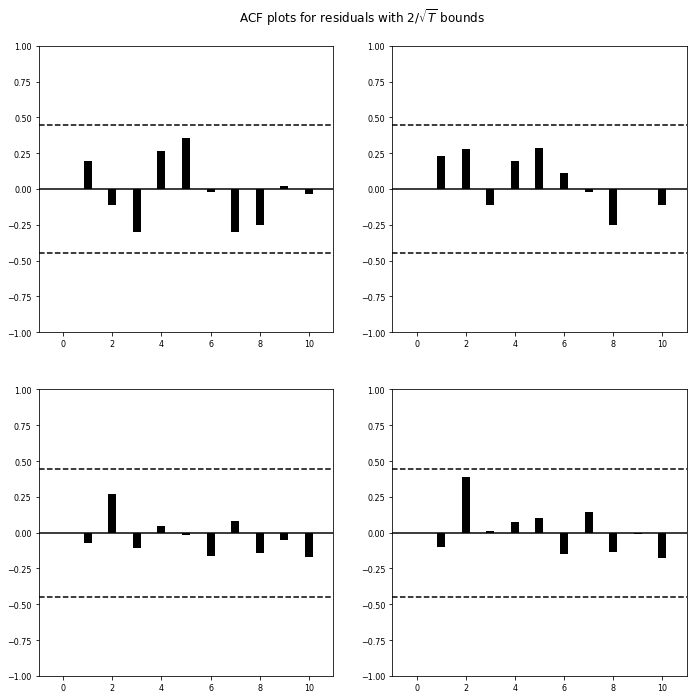

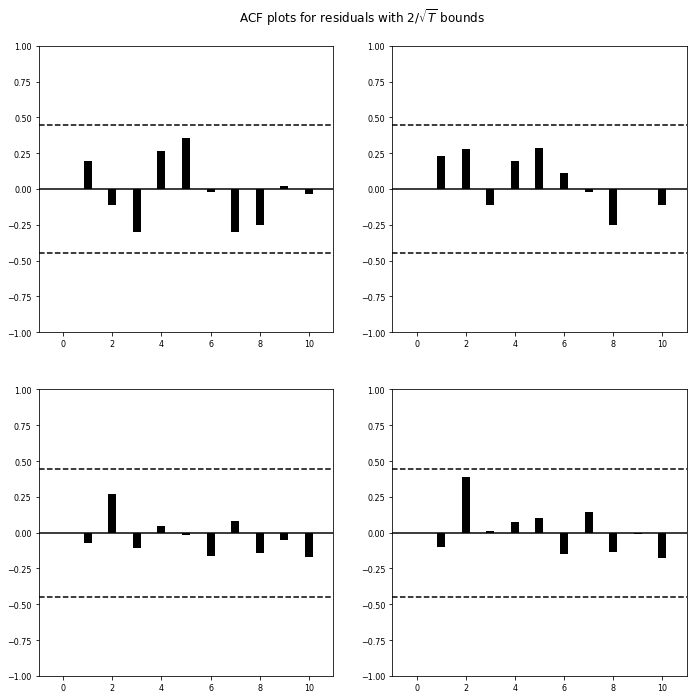

In [42]:
results.plot_acorr()

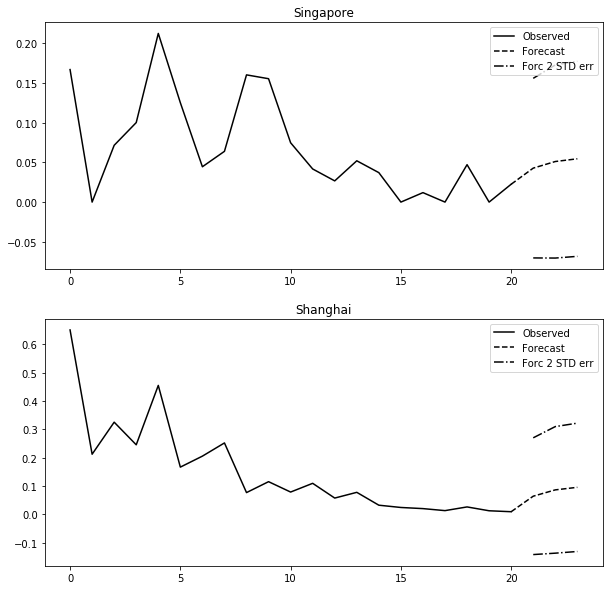

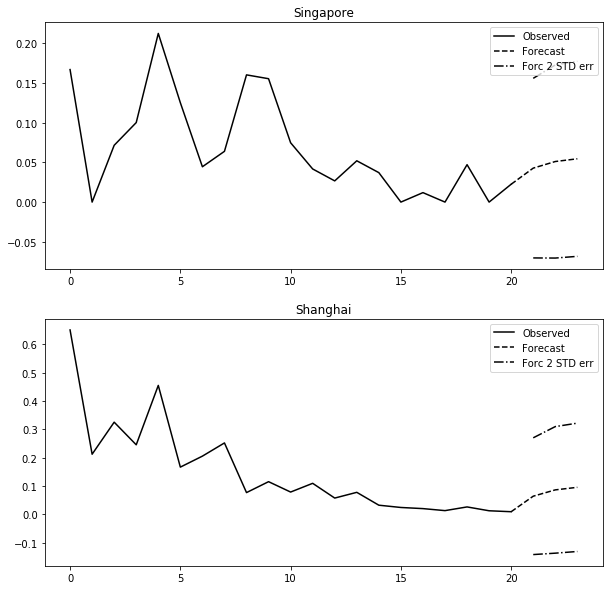

In [43]:
# Make forecast
results.plot_forecast(3)

In [44]:
# model_df[['Singapore','Hong Kong']]

# fcst_df

# fcst_df.loc[10,['Singapore','Hong Kong']].values

# np.array(fcst)

# np.array(fcst).flatten()

In [45]:
# day to be forecasted
day_forecat = model_df.index.max() + 1

In [46]:
fcst = results.forecast_interval(model_df[['Singapore','Shanghai']].values[-2:,:], 1)

In [47]:
fcst_df = heavy_affect_df[heavy_affect_df['Province/State'].isin(['Singapore','Shanghai'])].pivot(index ='day count',
                                                                                         columns = 'Province/State',
                                                                                        values = 'Confirmed')

In [48]:
fcst_num = ((np.array(fcst) + 1 ) * fcst_df.loc[day_forecat-1,['Singapore','Shanghai']].values).flatten()

In [49]:
fcst_df['Singapore_f_m'] = np.nan
fcst_df['Shanghai_f_m'] = np.nan
fcst_df['Singapore_f_lo'] = np.nan
fcst_df['Shanghai_f_lo'] = np.nan
fcst_df['Singapore_f_up'] = np.nan
fcst_df['Shanghai_f_up'] = np.nan

fcst_df.loc[day_forecat,['Singapore_f_m','Shanghai_f_m','Singapore_f_lo',
                'Shanghai_f_lo','Singapore_f_up','Shanghai_f_up']] = fcst_num

fcst_df.loc[day_forecat - 1, ['Singapore_f_m','Singapore_f_lo','Singapore_f_up']] = fcst_df.loc[day_forecat - 1,'Singapore']
fcst_df.loc[day_forecat - 1, ['Shanghai_f_m','Shanghai_f_lo','Shanghai_f_up']] = fcst_df.loc[day_forecat - 1,'Shanghai']

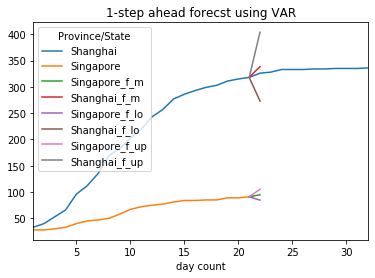

In [50]:
fcst_df.plot.line(title = '1-step ahead forecst using VAR')

### Recover rate using the latest data available

In [51]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()

latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Afghanistan,Afghanistan,02,24,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-24,NaN,NaN,NaN,0.000000
1,Afghanistan,Afghanistan,02,25,2020-02-24 21:33:02,1.0,0.0,0.0,2020-02-25,1.0,0.0,0.000000,0.000000
2,Algeria,Algeria,02,25,2020-02-25 21:43:03,1.0,0.0,0.0,2020-02-25,NaN,NaN,NaN,0.000000
3,Australia,Australia,01,26,2020-01-26 14:00:00,4.0,0.0,0.0,2020-01-26,4.0,0.0,0.000000,0.000000
4,Australia,New South Wales,02,13,2020-02-13 15:53:03,4.0,4.0,0.0,2020-02-13,4.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,United Arab Emirates,United Arab Emirates,02,22,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-22,9.0,4.0,0.444444,0.307692
491,United Arab Emirates,United Arab Emirates,02,23,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-23,13.0,0.0,0.000000,0.307692
492,United Arab Emirates,United Arab Emirates,02,24,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-24,13.0,0.0,0.000000,0.307692
493,United Arab Emirates,United Arab Emirates,02,25,2020-02-22 12:53:02,13.0,4.0,0.0,2020-02-25,13.0,0.0,0.000000,0.307692


Recovery over total confirmed cases: 34.35%


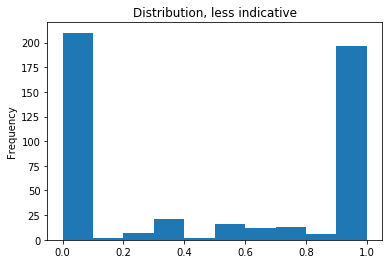

In [52]:
# Recovery rate
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Recovery over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

Mortality over total confirmed cases: 3.30%


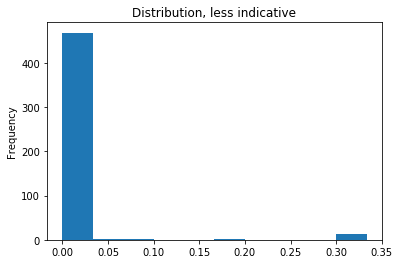

In [53]:
# Mortality rate
latest_df['mortality rate'] = latest_df.Deaths / latest_df.Confirmed
latest_df['mortality rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Mortality over total confirmed cases: {0:.2%}'.format(latest_df.Deaths.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [54]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [55]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)